In [16]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn, optim
from time import time

In [2]:
transform = transforms.ToTensor() #Definindo a conversão de imagem para tensor

trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) #Carrega a parte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) #Cria um buffer para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform) #Carrega a parte de validacao do dataset
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



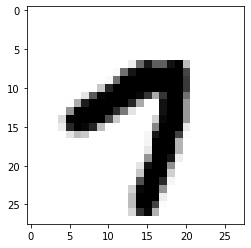

In [15]:
dataiter = iter(trainloader)
imagens, etiquetas = dataiter.next()
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r');

In [8]:
print(imagens[0].shape) #Verifica as dimensoes do tensor de cada imagem
print(etiquetas[0].shape) #Verifica as dimensoes do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [17]:
class Modelo(nn.Module):
  def __initi__(self):
    super(Modelo, self).__init__()
    self.linear1 = nn.Linear(28*28, 128) #Camada de entrada, 784 neuronios que se ligam a 128
    self.linear2 = nn.Linear(128, 64) #Camada interna 1, 128 neuronios que se ligam a 64
    self.linear3 = nn.Linear(64, 10) #Camada interna 2, 64 neuronios que se ligam a 10
    #Para a camada de saida nao e necessario definir nada pois so precisamos pegar o output da camada interna 2

  def forward(self, X):
    X = F.relu(self.linear1(X)) #Funcao de ativacao da camada de entrada para a camada interna
    X = F.relu(self.linear2(X)) #Funcao de ativacao da camada interna 1 para a camada interna 2
    X = self.linear3(X) #Funcao de ativacao da camada interna 2 para a camada de saida, nesse caso f(x) = x
    return F.log_softmax(X, dim=1)

In [18]:
def treino(modelo, trainloader, device):

  otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) #Define a politica e atualizacao dos pesos e das bias
  inicio = time() #Timer para sabermos quanto tempo levou o treino

  criterio = nn.NLLLoss() #Definindo o criterio para calcular a perda
  EPOCHS = 10 #numero de epochs que o algoritmo rodará
  modelo.train() #Ativando o modo de treinamento do modelo

  for epoch in range(EPOCHS):
    perda_acumulada = 0 #Inicializacao da perda acumulada da epoch em questao

    for imagens, etiquetas in trainloader:

      imagens = imagens.view(imagens.shape[0], -1) #Convertendo as imagens para "vetores" de 28*28 casas para ficarem compativeis
      otimizador.zero_grad() #Zerando os gradientes por conta do ciclo anterior

      output = modelo(imagens.to(device)) #Colocando os dados no modelo
      perda_instantanea = criterio(output, etiquetas.to(device)) #Calculando a perda da epoch em questao

      perda_instantanea.backward() #Back propagation a partir da perda

      otimizador.step() #Atualizando os pesos e as bias

      perda_acumulada += perda_instantanea.item() #Atualizacao da perda acumulada

    else:
      print('Epoch {} - Perda resultante: {}'.format(epoch+1, perda_acumulada/len(trainloader)))
    print('\nTempo de treino (em minutos) =', (time()-inicio)/60)

In [19]:
def validacao(modelo, valloader, device):
  conta_corretas, conta_todas = 0, 0
  for imagens, etiquetas in valloader:
    for i in range(len(etiquetas)):
      img = imagens[i].view(1, 784)
      #Desativar o autograd para acelerar a validacao. Grafos computacionais dinamicos tem um custo alto de processamento
      with torch.no_grad():
        logps = modelo(img.to(device)) #Output do modelo em escala logaritmica

      
      ps = torch.exp(logps) #Converte output para escala normal(lembrando que é um tensor)
      probab = list(ps.cpu().numpy()[0])
      etiqueta_pred = probab.index(max(probab)) #Converte o tensor em um numero, no caso, o numero que o modelo previu
      etiqueta_certa = etiquetas.numpy()[i]
      if(etiqueta_certa == etiqueta_pred): #Compara a previsao com o valor correto
        conta_corretas += 1
      conta_todas += 1

  print('Total de imagens testadas = ', conta_todas)
  print('\nPrecisao do modelo = {}%'.format(conta_corretas*100/conta_todas))

In [20]:
modelo = Modelo()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo.to(device)

Modelo()